## POOL DOGE_WETH
### Comparison simulation - volatility mitigator disabled/enabled

*VM parameters (custom):* 
- WINDOW_SIZE = 24h
- PERIOD_SIZE = 1h
- PRICE_TOLLERANCE_TRESHOLD = 98

In [78]:
import pandas as pd

In [79]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio

In [80]:
# set rendering mode 'notebook' for interactive view, 'svg' for export
pio.renderers.default = "svg"

In [81]:
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [82]:
EXPERIMENT_ID = 87

X_NAME = 'DOGE'
Y_NAME = 'WETH'

WINDOW_SIZE = 24 * 60 * 60

In [6]:
BASE_DIR = fr'..\..\..\data\real_transactions\experiment_{EXPERIMENT_ID}'

In [7]:
os.listdir(BASE_DIR)

['0', '1', 'config.txt']

In [8]:
def read_simulation(sim_id: int):
    pool_state_before_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_before_transaction_normalized.csv'
    pool_state_after_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_after_transaction_normalized.csv'
    swap_transactions_path = fr'{BASE_DIR}\\{sim_id}\swaps_normalized.csv'
    mint_transactions_path = fr'{BASE_DIR}\\{sim_id}\mints_normalized.csv'
    burn_transactions_path = fr'{BASE_DIR}\\{sim_id}\burns_normalized.csv'
    
    # read swaps
    pool0_df = pd.read_csv(pool_state_before_transactions_path)
    pool1_df = pd.read_csv(pool_state_after_transactions_path)
    swaps_df = pd.read_csv(swap_transactions_path)
    
    pool0_df.columns = pool0_df.columns.map(lambda x : x + '_before' if x != 'transaction_id' else x)

    swaps_df = pd.merge(swaps_df, pool0_df, left_on='id', right_on='transaction_id')
    swaps_df = pd.merge(swaps_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    swaps_df['transaction_timestamp'] = pd.to_datetime(swaps_df.transaction_timestamp, unit='s')
    swaps_df['block_timestamp'] = pd.to_datetime(swaps_df.block_timestamp, unit='s')
    
    swaps_df.loc[:, 'X_price'] = swaps_df['reserve_Y'] / swaps_df['reserve_X']
    
    # price impact of swap / 100%
    swaps_df.loc[:, 'price_diff'] = (swaps_df['reserve_Y'] / swaps_df['reserve_X'] - swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before']) / (swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before'])
    
    # read mints
    mints_df = pd.read_csv(mint_transactions_path)
    mints_df = pd.merge(mints_df, pool0_df, left_on='id', right_on='transaction_id')
    mints_df = pd.merge(mints_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    # read burns
    burns_df = pd.read_csv(burn_transactions_path)
    burns_df = pd.merge(burns_df, pool0_df, left_on='id', right_on='transaction_id')
    burns_df = pd.merge(burns_df, pool1_df, left_on='transaction_id', right_on='transaction_id') 
    
    return swaps_df, mints_df, burns_df

In [9]:
swaps0_df, mints0_df, burns0_df = read_simulation(0) # without vm
swaps1_df, mints1_df, burns1_df = read_simulation(1) # with vm

In [10]:
swaps0_df.head()

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,0,WETH,DOGE,1.000000,0.0,0.000000,NaN,NOT_REACHED,NaN,NaN,NaN,NaN,NOT_ENOUGH_RESERVES,0.0,2021-01-18 21:14:49,2021-01-18 21:14:49,0xebb57fcd4f7c7c8c155d6e5a80f3212c7f2d80640bb3...,0xb89fa54d5d7bcb78e121f9fa85cb47242355c68e,0xb89fa54d5d7bcb78e121f9fa85cb47242355c68e,0,0.000000e+00,0.000000,0.000000e+00,0,0,False,0.000000e+00,0.000000,0.000000e+00,0,0,False,NaN,NaN
1,2,WETH,DOGE,0.007725,0.0,1019.594013,0.000031,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,17.0,2021-01-18 21:19:04,2021-01-18 21:18:57,0x340d7456b432dd37e467d7a6fe3d6b3843e627d14d20...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x79d774e686d5d3cc1660ea4c88a11702b637852d,2,1.000000e+07,75.000000,7.500000e+08,0,0,False,9.998980e+06,75.007694,7.500005e+08,0,0,False,0.000008,0.000205
2,3,WETH,DOGE,0.041338,0.0,5452.504166,0.000165,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,60.0,2021-01-18 21:29:49,2021-01-18 21:29:35,0x0ea8f1609f74a727484e53da819e12a27159df3fdf6d...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x72478dcaaa7fc87718505daf7cb530ae9612e53a,3,9.998980e+06,75.007694,7.500005e+08,0,0,False,9.993528e+06,75.048867,7.500029e+08,0,85982410,False,0.000008,0.001095
3,4,WETH,DOGE,0.025787,0.0,3398.267916,0.000103,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,69.0,2021-01-18 21:32:04,2021-01-18 21:31:54,0xaddc432df998f8884ca9aa2bbe325f8df121cd5c3be6...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x212919050e84572e3feb9f7d2d47d061c46fa4da,4,9.993528e+06,75.048867,7.500029e+08,0,85982410,False,9.990130e+06,75.074550,7.500045e+08,0,103959048,False,0.000008,0.000683
4,8,WETH,DOGE,0.300000,0.0,38637.686625,0.001200,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,554.0,2021-01-18 23:33:19,2021-01-18 23:33:09,0xa834c8fbd15a81a708243b8f393877846e05b1e871b6...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x25770bc4f6b79ec5625c8e61bc92360caae23754,8,5.832849e+07,448.062215,2.613479e+10,0,103959048,False,5.828986e+07,448.361015,2.613490e+10,0,1051014574,False,0.000008,0.001330


In [11]:
swaps0_df.status.value_counts()

SUCCESS                12174
NOT_ENOUGH_RESERVES        1
Name: status, dtype: int64

In [12]:
swaps1_df.status.value_counts()

SUCCESS                             12155
BLOCKED_BY_VOLATILITY_MITIGATION       19
NOT_ENOUGH_RESERVES                     1
Name: status, dtype: int64

In [13]:
ratio_blocked_volatility = swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'].shape[0]/swaps1_df.shape[0] 

print(f"Blocked by volatility mitigator ratio: {ratio_blocked_volatility}")

Blocked by volatility mitigator ratio: 0.0015605749486652977


In [14]:
swaps1_df.mitigator_check_status.value_counts()

CHECKED                9044
CANT_CONSULT_ORACLE    3130
NOT_REACHED               1
Name: mitigator_check_status, dtype: int64

In [15]:
ratio_twap_not_available = swaps1_df[swaps1_df.mitigator_check_status == 'CANT_CONSULT_ORACLE'].shape[0]/swaps1_df.shape[0] 

print(f"TWAP not available ratio: {ratio_twap_not_available}")

TWAP not available ratio: 0.2570841889117043


In [16]:
# Check if all burns were completed successfully

print("Burns status without volatility mitigation mechanism")
print(burns0_df.status.value_counts())

print("\nBurns status with volatility mitigation mechanism")
print(burns0_df.status.value_counts())

Burns status without volatility mitigation mechanism
SUCCESS    16
Name: status, dtype: int64

Burns status with volatility mitigation mechanism
SUCCESS    16
Name: status, dtype: int64


Text(0.5, 1.0, 'Swaps slice_factor/out_amount_diff scatterplot (split by status)')

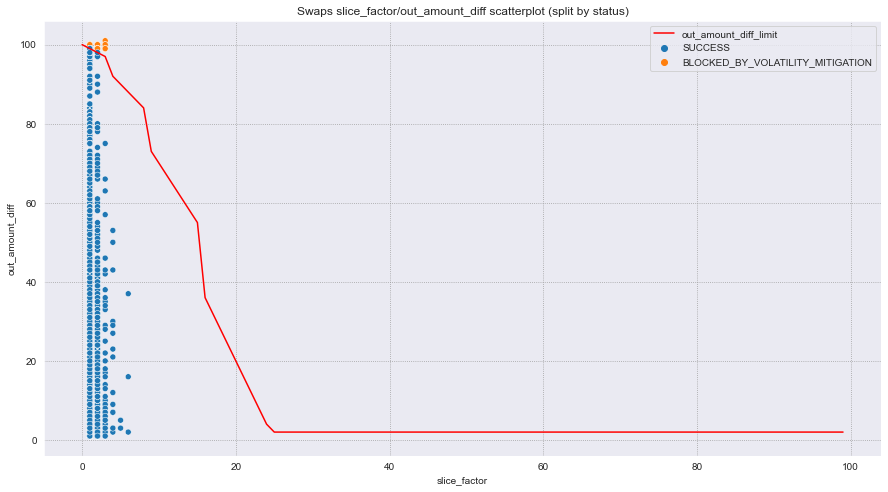

In [17]:
from scipy import stats

fig, ax = plt.subplots(figsize=(15, 8))
    
sns.scatterplot(data=swaps1_df[swaps1_df.mitigator_check_status == 'CHECKED'], x='slice_factor', y='out_amount_diff', hue='status')

slice_factor = np.arange(0, 100)
slice_factor_curve = slice_factor * np.sqrt(slice_factor).astype(int)
slice_factor_curve[slice_factor_curve > 98] = 98
out_amount_diff = (100 - slice_factor_curve)
sns.lineplot(x=slice_factor, y=out_amount_diff, color='red', label='out_amount_diff_limit')
ax.set_title('Swaps slice_factor/out_amount_diff scatterplot (split by status)')

The out_amount_diff_limit border is not smooth, because the slice_factor_curve is computed according to the formula slice_factor * sqrt(slice_factor), where the sqrt(slice_factor) is rounded down in the original contract

**As the reserves of the pool are very big, all of the swaps have a small slice_factor, despite their relatively big amount_in. In this case, the volatility mitigation mechanism kicks in only when the percentage price difference of the price with the one from oracle is near 100% or greater. There were several sudden price increases in the price of DOGE registered. More, on this, in the following sections**

Text(0, 0.5, 'Count')

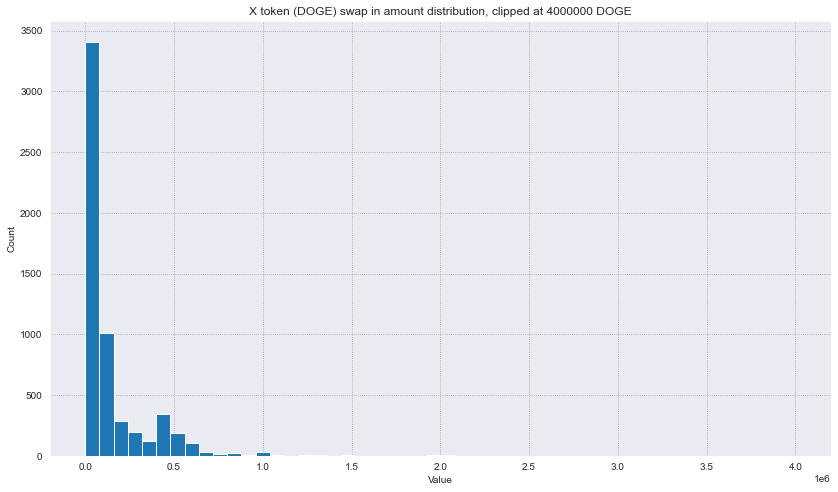

In [18]:
UPPER_LIMIT = 4000000

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == X_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"X token ({X_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {X_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

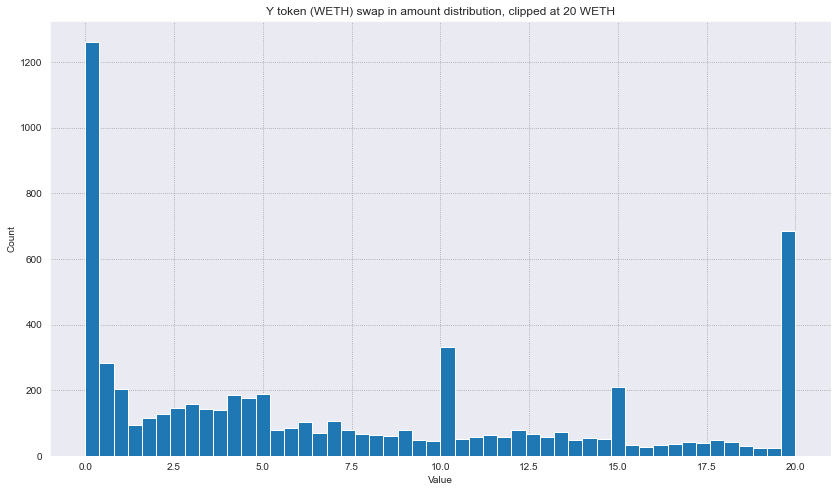

In [26]:
UPPER_LIMIT = 20

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {Y_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

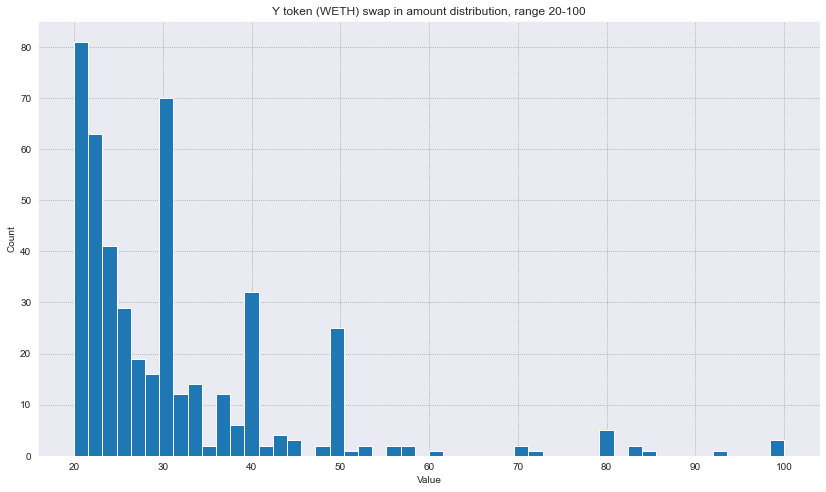

In [27]:
LOWER_LIMIT = 20
UPPER_LIMIT = 100
fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT
amounts = amounts[amounts > LOWER_LIMIT]
ax = amounts.hist(range=(LOWER_LIMIT, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, range {LOWER_LIMIT}-{UPPER_LIMIT}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

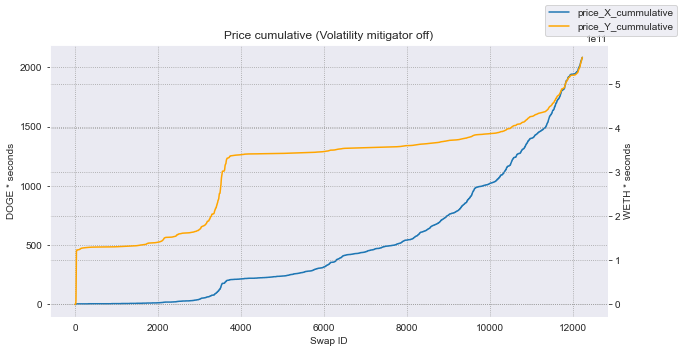

In [28]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.id, swaps0_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps0_df.id, swaps1_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator off)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

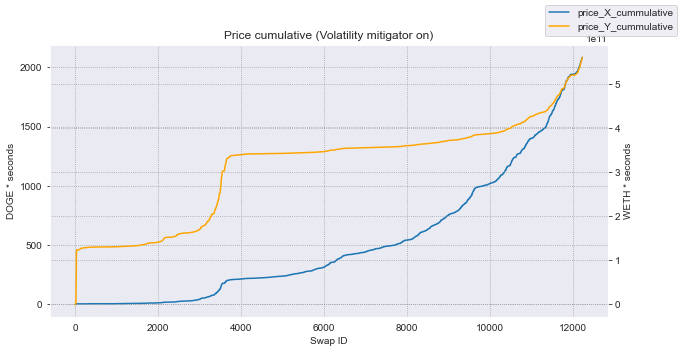

In [29]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.id, swaps1_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps1_df.id, swaps1_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator on)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

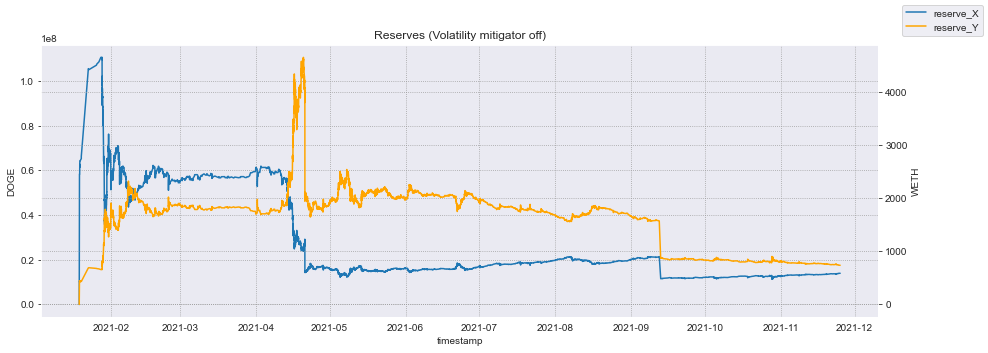

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_X, label='reserve_X')
ax2.plot(swaps0_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator off)')

fig.legend()

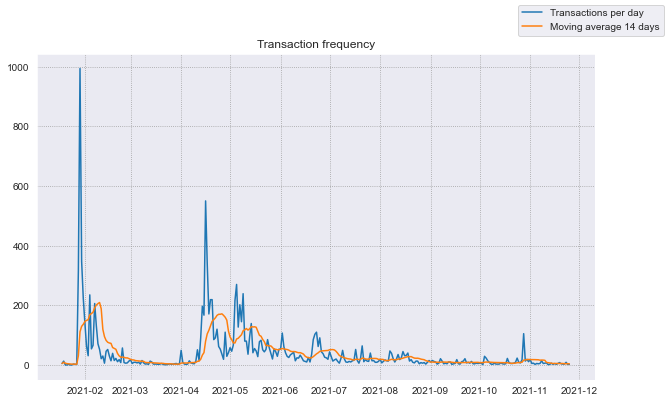

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))

sim1_indexed_df = swaps1_df.copy()
sim1_indexed_df.index = swaps1_df.transaction_timestamp
resampled = sim1_indexed_df.resample('24h').size()
mov_avg = resampled.rolling('14d').mean()

plt.plot_date(resampled.index, resampled.values, markersize=1, linestyle='solid', marker='None', label='Transactions per day')
plt.plot_date(mov_avg.index, mov_avg.values, markersize=1, linestyle='solid', marker='None', label='Moving average 14 days')

ax.set_title('Transaction frequency')
fig.legend()

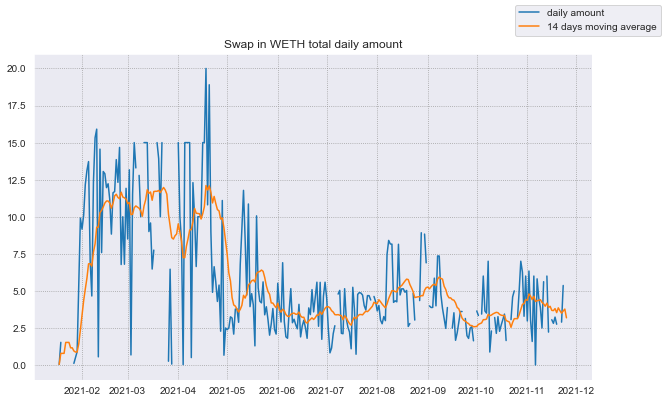

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))

sim1_indexed_df = swaps1_df[swaps1_df.token_in == Y_NAME].copy()
sim1_indexed_df.index = sim1_indexed_df.transaction_timestamp
resampled = sim1_indexed_df.resample('24h').median().token_in_amount
mov_avg = resampled.rolling('14d').mean()

plt.plot_date(resampled.index, resampled.values, markersize=1, linestyle='solid', marker='None', label='daily amount')
plt.plot_date(mov_avg.index, mov_avg.values, markersize=1, linestyle='solid', marker='None', label='14 days moving average')

ax.set_title(f'Swap in {Y_NAME} total daily amount')
fig.legend()

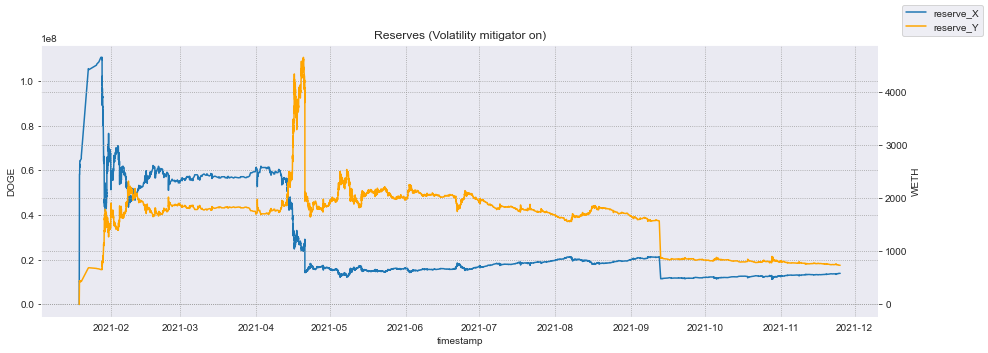

In [52]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator on)')

fig.legend()

**As no transactions have been blocked, the variation of reserves over time with and without the volatility mitigation mechanism is the same**

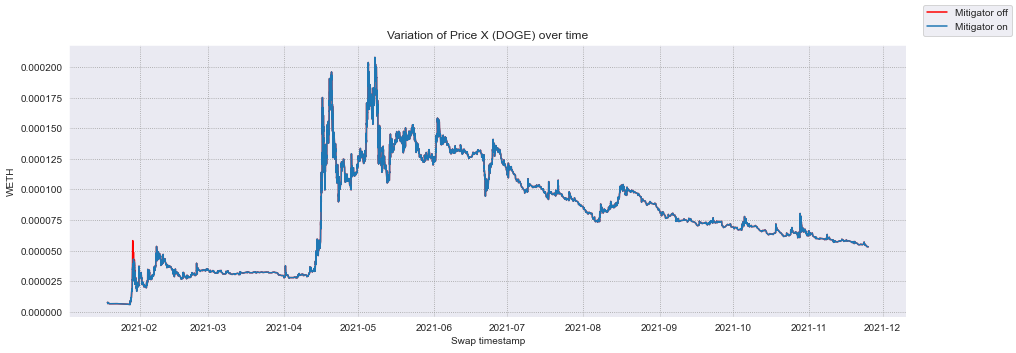

In [63]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=swaps0_df['transaction_timestamp'], y=swaps0_df['X_price'], linestyle='solid', marker=None, label='Mitigator off', color='red')
ax.plot_date(x=swaps1_df['transaction_timestamp'], y=swaps1_df['X_price'], linestyle='solid', marker=None, label='Mitigator on',)

ax.set_title(f'Variation of Price X ({X_NAME}) over time')
#ax.set_ylim(0, 0.1)
ax.set_xlabel('Swap timestamp')
ax.set_ylabel(Y_NAME)
fig.legend()

In [86]:
burns0_df['Date'] = pd.to_datetime(burns0_df['timestamp'], unit='s')
burns0_df

,id,X_amount,Y_amount,timestamp,status,block_number,block_timestamp,transaction_timestamp,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,Date
0,1119,6.894842e+04,2.655201,1611929704,SUCCESS,61681,1611929704,1611929704,1119,4.411730e+07,1697.468564,7.488773e+10,8,131365240111,False,4.404835e+07,1694.813363,7.465373e+10,8,131365240111,False,2021-01-29 14:15:04
1,1468,3.185133e+03,0.084567,1611982883,SUCCESS,65227,1611982894,1611982883,1468,6.044784e+07,1606.891691,9.713312e+10,9,132923802486,False,6.044465e+07,1606.807123,9.712289e+10,9,132923802486,False,2021-01-30 05:01:23
2,2769,2.528739e+03,0.112135,1612766707,SUCCESS,117482,1612766719,1612766707,2769,4.800389e+07,2116.659341,1.016079e+11,31,162600551780,False,4.800136e+07,2116.547206,1.015972e+11,31,162600551780,False,2021-02-08 06:45:07
3,2860,3.643306e+03,0.169095,1612839098,SUCCESS,122308,1612839109,1612839098,2860,4.697829e+07,2167.933016,1.018458e+11,34,164244221818,False,4.697465e+07,2167.763921,1.018300e+11,34,164244221818,False,2021-02-09 02:51:38
4,3248,1.480797e+04,0.414450,1613846161,SUCCESS,189445,1613846164,1613846161,3248,6.086067e+07,1696.841246,1.032709e+11,68,193959446539,False,6.084586e+07,1696.426796,1.032206e+11,68,193959446539,False,2021-02-20 18:36:01
5,3525,3.023294e+03,0.096621,1616832989,SUCCESS,388567,1616832994,1616832989,3525,5.718301e+07,1823.484379,1.042723e+11,163,286457055544,False,5.717999e+07,1823.387758,1.042613e+11,163,286457055544,False,2021-03-27 08:16:29
6,5640,1.378062e+07,1857.350311,1618952213,SUCCESS,529849,1618952224,1618952213,5640,2.868692e+07,3879.038519,1.112777e+11,281,344363875132,False,1.490631e+07,2021.688208,3.013590e+10,281,344363875132,False,2021-04-20 20:56:53
7,6560,1.273397e+02,0.017883,1620125687,SUCCESS,608080,1620125689,1620125687,6560,1.491922e+07,2064.789537,3.080505e+10,419,354422418070,False,1.491910e+07,2064.771654,3.080452e+10,419,354422418070,False,2021-05-04 10:54:47
8,6819,1.511696e+03,0.318917,1620195299,SUCCESS,612721,1620195304,1620195299,6819,1.231962e+07,2511.081943,3.093558e+10,431,354851445128,False,1.231811e+07,2510.763026,3.092785e+10,431,354851445128,False,2021-05-05 06:14:59
9,7261,1.912582e+03,0.364567,1620423983,SUCCESS,627967,1620423994,1620423983,7261,1.288549e+07,2422.560452,3.121587e+10,471,356153715063,False,1.288357e+07,2422.195885,3.120654e+10,471,356153715063,False,2021-05-07 21:46:23


In [93]:
s = swaps0_df.transaction_timestamp
s

0       2021-01-18 21:14:49
1       2021-01-18 21:18:57
2       2021-01-18 21:29:35
3       2021-01-18 21:31:54
4       2021-01-18 23:33:09
                ...        
12170   2021-11-23 19:12:01
12171   2021-11-24 08:18:12
12172   2021-11-24 09:58:15
12173   2021-11-25 00:15:15
12174   2021-11-25 02:40:41
Name: transaction_timestamp, Length: 12175, dtype: datetime64[ns]

In [118]:
swaps0_df

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,0,WETH,DOGE,1.000000,0.0,0.000000,NaN,NOT_REACHED,NaN,NaN,NaN,NaN,NOT_ENOUGH_RESERVES,0.0,2021-01-18 21:14:49,2021-01-18 21:14:49,0xebb57fcd4f7c7c8c155d6e5a80f3212c7f2d80640bb3...,0xb89fa54d5d7bcb78e121f9fa85cb47242355c68e,0xb89fa54d5d7bcb78e121f9fa85cb47242355c68e,0,0.000000e+00,0.000000,0.000000e+00,0,0,False,0.000000e+00,0.000000,0.000000e+00,0,0,False,NaN,NaN
1,2,WETH,DOGE,0.007725,0.0,1019.594013,0.000031,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,17.0,2021-01-18 21:19:04,2021-01-18 21:18:57,0x340d7456b432dd37e467d7a6fe3d6b3843e627d14d20...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x79d774e686d5d3cc1660ea4c88a11702b637852d,2,1.000000e+07,75.000000,7.500000e+08,0,0,False,9.998980e+06,75.007694,7.500005e+08,0,0,False,0.000008,0.000205
2,3,WETH,DOGE,0.041338,0.0,5452.504166,0.000165,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,60.0,2021-01-18 21:29:49,2021-01-18 21:29:35,0x0ea8f1609f74a727484e53da819e12a27159df3fdf6d...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x72478dcaaa7fc87718505daf7cb530ae9612e53a,3,9.998980e+06,75.007694,7.500005e+08,0,0,False,9.993528e+06,75.048867,7.500029e+08,0,85982410,False,0.000008,0.001095
3,4,WETH,DOGE,0.025787,0.0,3398.267916,0.000103,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,69.0,2021-01-18 21:32:04,2021-01-18 21:31:54,0xaddc432df998f8884ca9aa2bbe325f8df121cd5c3be6...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x212919050e84572e3feb9f7d2d47d061c46fa4da,4,9.993528e+06,75.048867,7.500029e+08,0,85982410,False,9.990130e+06,75.074550,7.500045e+08,0,103959048,False,0.000008,0.000683
4,8,WETH,DOGE,0.300000,0.0,38637.686625,0.001200,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,554.0,2021-01-18 23:33:19,2021-01-18 23:33:09,0xa834c8fbd15a81a708243b8f393877846e05b1e871b6...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x25770bc4f6b79ec5625c8e61bc92360caae23754,8,5.832849e+07,448.062215,2.613479e+10,0,103959048,False,5.828986e+07,448.361015,2.613490e+10,0,1051014574,False,0.000008,0.001330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12170,12212,DOGE,WETH,3100.579942,0.0,0.167324,0.000669,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1779349.0,2021-11-23 19:12:04,2021-11-23 19:12:01,0x7a086f670f8a3ce344a58cc76a01e204816de742e422...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,12212,1.376499e+07,750.502507,1.033066e+10,2077,558373237420,False,1.376809e+07,750.334514,1.033067e+10,2077,558544909487,False,0.000054,-0.000449
12171,12213,DOGE,WETH,38241.829903,0.0,2.057607,0.008230,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1782494.0,2021-11-24 08:18:19,2021-11-24 08:18:12,0xdb47f7f45ec9f7f5a5650ead3a206b2c3d61c0de4bf6...,0xb2bbfd73971279a457514325f209eb63a0341ef2,0xb2bbfd73971279a457514325f209eb63a0341ef2,12213,1.376809e+07,750.334514,1.033067e+10,2077,558544909487,False,1.380633e+07,748.268677,1.033085e+10,2080,559410536370,False,0.000054,-0.005515
12172,12214,DOGE,WETH,100000.000000,0.0,5.327351,0.021309,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1782894.0,2021-11-24 09:58:19,2021-11-24 09:58:15,0xc3a2b979eae3d49d64d85863c9578c987f9732089aa1...,0x1111111254fb6c44bac0bed2854e76f90643097d,0x0d4a11d5eeaac28ec3f61d100daf4d40471f1852,12214,1.380633e+07,748.268677,1.033085e+10,2080,559410536370,False,1.390633e+07,742.920016,1.033129e+10,2080,559521242596,False,0.000053,-0.014288
12173,12215,DOGE,WETH,40517.171810,0.0,2.136746,0.008547,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1786322.0,2021-11-25 00:15:19,2021-11-25 00:15:15,0x5bd

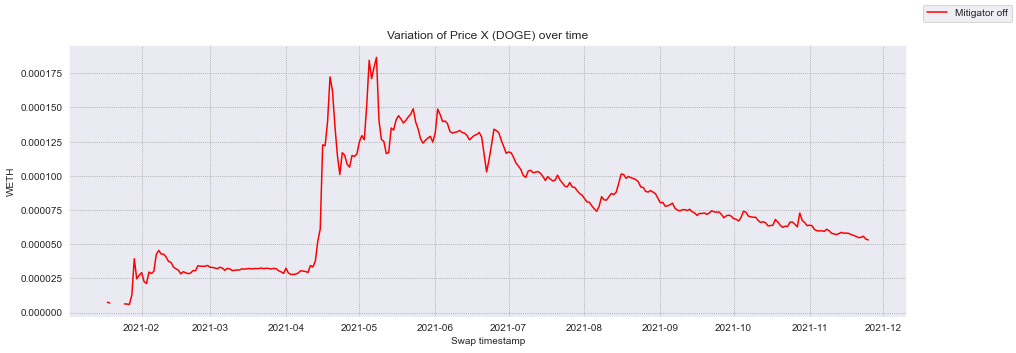

In [133]:
s = swaps0_df.copy()
s.index = s.transaction_timestamp
s = s.resample('1D').X_price.mean()

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=s.index, y=s, linestyle='solid', marker=None, label='Mitigator off', color='red')

ax.set_title(f'Variation of Price X ({X_NAME}) over time')
#ax.set_ylim(0, 0.1)
ax.set_xlabel('Swap timestamp')
ax.set_ylabel(Y_NAME)
fig.legend()

In [129]:
swaps0_df

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,0,WETH,DOGE,1.000000,0.0,0.000000,NaN,NOT_REACHED,NaN,NaN,NaN,NaN,NOT_ENOUGH_RESERVES,0.0,2021-01-18 21:14:49,2021-01-18 21:14:49,0xebb57fcd4f7c7c8c155d6e5a80f3212c7f2d80640bb3...,0xb89fa54d5d7bcb78e121f9fa85cb47242355c68e,0xb89fa54d5d7bcb78e121f9fa85cb47242355c68e,0,0.000000e+00,0.000000,0.000000e+00,0,0,False,0.000000e+00,0.000000,0.000000e+00,0,0,False,NaN,NaN
1,2,WETH,DOGE,0.007725,0.0,1019.594013,0.000031,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,17.0,2021-01-18 21:19:04,2021-01-18 21:18:57,0x340d7456b432dd37e467d7a6fe3d6b3843e627d14d20...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x79d774e686d5d3cc1660ea4c88a11702b637852d,2,1.000000e+07,75.000000,7.500000e+08,0,0,False,9.998980e+06,75.007694,7.500005e+08,0,0,False,0.000008,0.000205
2,3,WETH,DOGE,0.041338,0.0,5452.504166,0.000165,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,60.0,2021-01-18 21:29:49,2021-01-18 21:29:35,0x0ea8f1609f74a727484e53da819e12a27159df3fdf6d...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x72478dcaaa7fc87718505daf7cb530ae9612e53a,3,9.998980e+06,75.007694,7.500005e+08,0,0,False,9.993528e+06,75.048867,7.500029e+08,0,85982410,False,0.000008,0.001095
3,4,WETH,DOGE,0.025787,0.0,3398.267916,0.000103,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,69.0,2021-01-18 21:32:04,2021-01-18 21:31:54,0xaddc432df998f8884ca9aa2bbe325f8df121cd5c3be6...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x212919050e84572e3feb9f7d2d47d061c46fa4da,4,9.993528e+06,75.048867,7.500029e+08,0,85982410,False,9.990130e+06,75.074550,7.500045e+08,0,103959048,False,0.000008,0.000683
4,8,WETH,DOGE,0.300000,0.0,38637.686625,0.001200,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,554.0,2021-01-18 23:33:19,2021-01-18 23:33:09,0xa834c8fbd15a81a708243b8f393877846e05b1e871b6...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x25770bc4f6b79ec5625c8e61bc92360caae23754,8,5.832849e+07,448.062215,2.613479e+10,0,103959048,False,5.828986e+07,448.361015,2.613490e+10,0,1051014574,False,0.000008,0.001330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12170,12212,DOGE,WETH,3100.579942,0.0,0.167324,0.000669,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1779349.0,2021-11-23 19:12:04,2021-11-23 19:12:01,0x7a086f670f8a3ce344a58cc76a01e204816de742e422...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,12212,1.376499e+07,750.502507,1.033066e+10,2077,558373237420,False,1.376809e+07,750.334514,1.033067e+10,2077,558544909487,False,0.000054,-0.000449
12171,12213,DOGE,WETH,38241.829903,0.0,2.057607,0.008230,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1782494.0,2021-11-24 08:18:19,2021-11-24 08:18:12,0xdb47f7f45ec9f7f5a5650ead3a206b2c3d61c0de4bf6...,0xb2bbfd73971279a457514325f209eb63a0341ef2,0xb2bbfd73971279a457514325f209eb63a0341ef2,12213,1.376809e+07,750.334514,1.033067e+10,2077,558544909487,False,1.380633e+07,748.268677,1.033085e+10,2080,559410536370,False,0.000054,-0.005515
12172,12214,DOGE,WETH,100000.000000,0.0,5.327351,0.021309,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1782894.0,2021-11-24 09:58:19,2021-11-24 09:58:15,0xc3a2b979eae3d49d64d85863c9578c987f9732089aa1...,0x1111111254fb6c44bac0bed2854e76f90643097d,0x0d4a11d5eeaac28ec3f61d100daf4d40471f1852,12214,1.380633e+07,748.268677,1.033085e+10,2080,559410536370,False,1.390633e+07,742.920016,1.033129e+10,2080,559521242596,False,0.000053,-0.014288
12173,12215,DOGE,WETH,40517.171810,0.0,2.136746,0.008547,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1786322.0,2021-11-25 00:15:19,2021-11-25 00:15:15,0x5bd

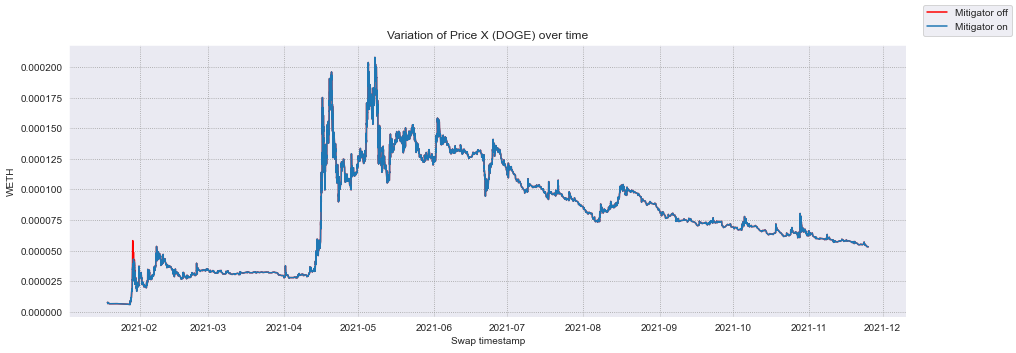

In [119]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=swaps0_df['transaction_timestamp'], y=swaps0_df['X_price'], linestyle='solid', marker=None, label='Mitigator off', color='red')
ax.plot_date(x=swaps1_df['transaction_timestamp'], y=swaps1_df['X_price'], linestyle='solid', marker=None, label='Mitigator on',)

ax.set_title(f'Variation of Price X ({X_NAME}) over time')
#ax.set_ylim(0, 0.1)
ax.set_xlabel('Swap timestamp')
ax.set_ylabel(Y_NAME)
fig.legend()

**The variation of price is also the same**

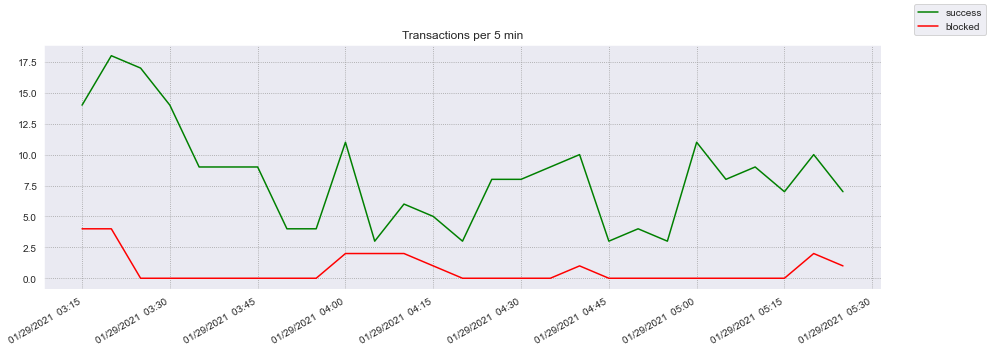

In [77]:
import matplotlib.dates as mdates

sim1_indexed_blocked_df = swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION']
sim1_indexed_blocked_df.index = sim1_indexed_blocked_df.transaction_timestamp
resampled_blocked = sim1_indexed_blocked_df.resample('5min').size()

sim1_indexed_success_df = swaps1_df[swaps1_df.status == 'SUCCESS']
sim1_indexed_success_df.index = sim1_indexed_success_df.transaction_timestamp
resampled_success = sim1_indexed_success_df.resample('5min').size()

resampled_success = resampled_success[(resampled_success.index >= resampled_blocked.index.min()) & (resampled_success.index <= resampled_blocked.index.max())]

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=resampled_success.index, y=resampled_success, linestyle='solid', marker=None, color='green', label='success')
ax.plot_date(x=resampled_blocked.index, y=resampled_blocked, linestyle='solid', marker=None, color='red', label='blocked')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y  %H:%M'))

fig.legend()
ax.set_title('Transactions per 5 min')
plt.gcf().autofmt_xdate()

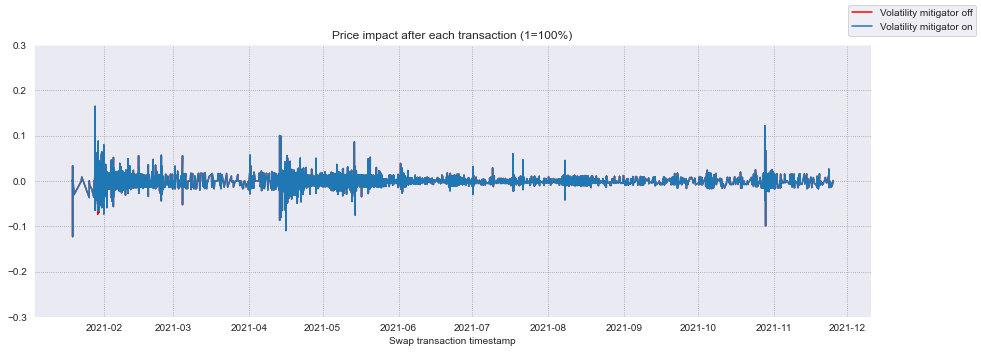

In [59]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(data=swaps0_df, x='transaction_timestamp', y='price_diff', linestyle='solid', color='red', marker=None, label='Volatility mitigator off')
ax.plot_date(data=swaps1_df, x='transaction_timestamp', y='price_diff', linestyle='solid', marker=None, label='Volatility mitigator on')

ax.set_ylim(-0.3, 0.3)
ax.set_xlabel('Swap transaction timestamp')
ax.set_title('Price impact after each transaction (1=100%)')
fig.legend()

**The price impact after each transaction doesn't exceed 0.25**